In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from opencc import OpenCC
import jieba
import random

from keras.models import Sequential
from keras.layers import Dense
from keras.layers.merge import add
from keras.layers import LSTM,Bidirectional, Dropout,GRU
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
def performance(y, y_hat):
    print("accuracy: {}".format(accuracy_score(y, y_hat,normalize=False)))
    print("precision: {}".format(precision_score(y, y_hat,average='micro')))
    print("recall: {}".format(recall_score(y, y_hat)))
    print("roc_auc: {}".format(roc_auc_score(y, y_hat)))

# 读取数据

In [3]:
data = pd.read_csv('D:/senior/aiCourse/dataSource/comment_classification/train/sentiment_analysis_trainingset.csv',encoding='UTF-8')

In [4]:
data.count

<bound method DataFrame.count of             id                                            content  \
0            0  "吼吼吼，萌死人的棒棒糖，中了大众点评的霸王餐，太可爱了。一直就好奇这个棒棒糖是怎么个东西，...   
1            1  "第三次参加大众点评网霸王餐的活动。这家店给人整体感觉一般。首先环境只能算中等，其次霸王餐提...   
2            2  "4人同行 点了10个小吃\n榴莲酥 榴莲味道不足 松软 奶味浓\n虾饺 好吃 两颗大虾仁\...   
3            3  "之前评价了莫名其妙被删 果断继续差评！ 换了菜单 价格更低 开始砸牌子 但套餐还是有150...   
4            4  "出乎意料地惊艳，椰子鸡清热降火，美容养颜，大大满足了爱吃火锅怕上火星人。椰子冻是帅帅的老板...   
5            5  "烤鸭使用的蘸酱很地道，觉得烤鸭好不好吃在很大程度上都取决于这个酱料是否正宗。个人感觉他们家...   
6            6  "在好友圈很红的原因很诡异.竟然基本都是我外地的朋友转发的.不远千里跑来厦门买回去吃.吃完各...   
7            7  "中午饭点人比较多需要排队～2点左右去吃的刚好可以用团购～也不用排队～就是平安夜店员说的都不...   
8            8  "跟朋友相约25号看港囧，首映当天排片率超高，为了提前订好票，选了文投国际影城，为了看电影我...   
9            9  "首先感谢大众点评再次抽中我免费品尝火锅，同时也感谢古蜀雒味三星堆主题火锅商家提供这个平台，...   
10          10  "这次必须给全五分！因为太完美了！整个就餐体验相当棒！\n口味：菜品做的都很干净！有图有真相...   
11          11  "突然特别想吃点重口味的，就和老公商量了去吃辣府。以前都不太敢吃辣的。没想到不是周末都要排队...   
12          12  "和闺蜜相约欧亚达鱼酷，三个人竟然喜欢不同口味，最后只得放弃我最爱的黄金酸辣，吃的油泼香辣口...   
1

In [5]:
#填充空白格
data['content'] = data['content'].fillna('')

In [6]:
sample = 100
random_indices = np.random.choice(np.arange(len(data['content'])), sample)
sub_data = data.iloc[random_indices]

In [7]:
sub_data.head()

,id,content,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
101785,101785,"""很高兴能中霸王餐。最初申请时没有太注意，只看到是在万达，中了后一看是四楼。我就在想四楼不是...",-2,1,1,-2,0,-2,-2,-1,...,1,-2,-2,-2,-1,0,-2,-2,0,-2
17524,17524,"""中了霸王餐，看了点评才决定去的，但是个人感觉并不想点评里说的那么好，很一般。首先环境还可以...",-2,-2,1,-2,0,-2,-2,0,...,1,1,1,1,-1,0,-2,-2,0,-2
30602,30602,"""这家店真的好难找啊！！我其实最终也没找到店在哪儿，是他们业务员给送下来的。\n中秋有朋友给...",-1,-2,-1,-2,0,-2,-2,-2,...,-2,-2,-2,-2,-2,1,-2,-2,0,-2
92130,92130,"""首先感谢大众点评一直以来对我的厚爱，真是不枉我这个铁杆粉丝啊，每每外出觅食都会上大众看下这...",-2,-2,-2,-2,1,-2,-2,-2,...,-2,-2,-2,-2,-2,1,-2,-2,1,1
38059,38059,"""西宁也终于开了家川西坝子，太期盼了，以前在成都的时候吃火锅会选择这里，西宁的这家位于城西区...",-2,-2,-2,-2,0,-2,-2,-2,...,1,-2,-2,-2,1,1,1,-2,1,-2


# 预处理，主要处理content字段

In [8]:

def is_CN_char(ch):
    return ch >= u'\u4e00' and ch <= u'\u9fa5'

def cut(string):
    return list(jieba.cut(string))

def get_stopwords(filename = "D:/senior/aiCourse/dataSource/stop_word.txt"):
    stopwords_dic = open(filename, encoding= 'utf-8')
    stopwords = stopwords_dic.readlines()
    stopwords = [w.strip() for w in stopwords]
    stopwords_dic.close()
    return stopwords

def convert2simple(word):
    openCC = OpenCC('tw2sp')
    return openCC.convert(word)

In [9]:
stopwords = get_stopwords()

In [10]:
def clean_sentence(sentence):
    stopwords = get_stopwords()
    sentence = ''.join(filter(is_CN_char,sentence))
    #print(sentence)
    
    
    sentence = convert2simple(sentence)
    words = [w for w in cut(sentence) if len(w)>0 and w not in stopwords]
    #print(words)
    words = ' '.join(words)
    return words  

In [11]:
clean_sentence("哈哈哈哈哈")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Andywong\AppData\Local\Temp\jieba.cache
Loading model cost 1.222 seconds.
Prefix dict has been built succesfully.


'哈哈哈 哈哈'

In [12]:
result = sub_data['content'].apply(clean_sentence)

In [18]:
result.tolist()

['高兴 霸王餐 最初 申请 时 只 在 万达 后 四楼 在 四楼 只有 电影院 吗 餐馆 昨天 特意 选 在 万达 影院 港 囧 无名 小排 还好 太难 找 位置 从 以前 万达 三楼 百货 一部 电梯 从 电梯 四楼 后小排 在 你 左手边 四楼 开放式 餐馆 环境 刚刚 开业 在 四楼 吃饭 人 很少 晚上 六点 多去 人 装修 日式 古朴 装修 色调 偏暗 服务态度 特别 可说 不好不坏 中规中矩 有问必答 需求 回复 味道 此次 霸王餐 量 一人餐 量 不大 如果 其写 价格 元 很贵 我点 鸡 排炸 很脆 味道 可以 增味 汤 不 喜欢 白萝卜 味道 太重 害 以为 纯粹 萝卜汤 里面 蘑菇 土豆 东西 服务员 倒 一杯 水什幺 味道 不 记得 反正 有种 怪 味道 没 在 喝 一口 他家 最最 出色 蘸 料 自制 白芝麻 研磨 后 放入 蘸 料味美 结论 量 小价贵 除了 自制 蘸 料 其他 只是',
 '霸王餐 点评 才 决定 但是 个人感觉 并 不想 点评 好 首先 环境 可以 在 某家 店铺 二楼 仔细 找 容易 找到 靠窗 位子 环境 干净 服务员 态度 不错 来说 菜品 霸王餐 含 三斤 左右 烤鱼 五个 配菜 一份 炒花 蛤 一扎 柚子 饮料 烤鱼 青鱼 换 龙利鱼 问 才 奇怪 为 霸王餐 青鱼 呢 龙利鱼 便宜 好 操作 呢 喜欢 莴笋 特地 加 一份 烤鱼 后 发现 配菜 量 非常少 几乎 别的 烤鱼 一半 应该 土豆 莴笋 只有 片 于是 问 服务员 单加 莴笋 几片 回答 告诉 他们 土豆片 经理 蛮 好 加 一盘 莴笋 那个 量 才 分量 好 烤鱼 豆豉 味 但 入味 炒花 蛤 味道 可以 辣辣的 十几个 闭口 套餐 如果 花钱 肯定 不值 本来 点个 小龙虾 鱼 之后 打消 念头',
 '真的 好难 找 最终 没 找到 在 哪儿 他们 业务员 送 中秋 朋友 送 月饼 券 他家 打电话 拿额 从 北郊 西南 好 在 老纸 正好 在 南郊 公司 加班 便 打算 加完 班 加完 班 背着 重重的 电脑 下 公交 走 好 远 好 远 没 找 店面 打电话 老板 老板 送 摸 裙 兜 发现 卡 丢 打电话 老板 送 卡 丢 老板 送 再次 傻眼 单行道 打车 得 出去 月饼 里面 黑豆 红豆 黑芝麻 各俩 话梅 开心果 各 一盒 月饼

In [ ]:
sub_data['content'][:10]

In [ ]:
from wordcloud import WordCloud

In [ ]:
wc = WordCloud(
        background_color='white', font_path='D://senior/aiCourse/dataSource/SourceHanSerifSC-Regular.otf'       
    )

In [ ]:
worddata = ''.join(sub_data['content'].tolist())

In [ ]:
wc.generate_from_text(worddata)

In [ ]:
wc.to_file('comment_wc.png')

In [14]:
def word_to_id(vocab):
    counts = Counter(vocab)
    #print(counts)
    vocab = sorted(counts, key=counts.get, reverse=True)
    word_to_id = { word : i for i, word in enumerate(vocab)}
    id_to_word = {i:word for i,word in enumerate(vocab)}
    return word_to_id, id_to_word

In [15]:
vocab = ' '.join(sub_data['content']).split()
vocab.append('unknown')
word_to_id, id_to_word = word_to_id(vocab)

In [16]:
type(vocab)

list

In [17]:
def comment_to_id(word_to_id,comments):
    comment_to_id = []
    for comment in comments:
        comment_to_id.append([word_to_id[word] for word in comment.split()] )
    return comment_to_id

In [18]:
comment_to_id = comment_to_id(word_to_id,sub_data['content'])

In [19]:
def pad_sequences(comment_to_id,maxlen,padding,truncating):
    features = np.zeros((len(comment_to_id), maxlen), dtype=int)
    for i,comment in enumerate(comment_to_id):
        if len(comment) <= maxlen and padding == 'pre':
            features[i, -len(comment):] = np.array(comment)[:maxlen]
        if len(comment) <= maxlen and padding == 'post':
            features[i, :len(comment)] = np.array(comment)[:maxlen]
        if len(comment) > maxlen and truncating == 'post':
            features[i, :] = np.array(comment)[:maxlen]
        if len(comment) > maxlen and truncating == 'pre':
            features[i, :] = np.array(comment)[len(comment)-maxlen:]           
    return features

In [20]:
pad_comments = pad_sequences(comment_to_id,maxlen=200,padding='post',truncating='post')

In [21]:
pad_comments.shape

(1000, 200)

In [22]:
data.columns

Index(['id', 'content', 'location_traffic_convenience',
       'location_distance_from_business_district', 'location_easy_to_find',
       'service_wait_time', 'service_waiters_attitude',
       'service_parking_convenience', 'service_serving_speed', 'price_level',
       'price_cost_effective', 'price_discount', 'environment_decoration',
       'environment_noise', 'environment_space', 'environment_cleaness',
       'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
       'others_overall_experience', 'others_willing_to_consume_again'],
      dtype='object')

In [23]:
labels = sub_data[[ 'location_traffic_convenience',
       'location_distance_from_business_district', 'location_easy_to_find',
       'service_wait_time', 'service_waiters_attitude',
       'service_parking_convenience', 'service_serving_speed', 'price_level',
       'price_cost_effective', 'price_discount', 'environment_decoration',
       'environment_noise', 'environment_space', 'environment_cleaness',
       'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
       'others_overall_experience', 'others_willing_to_consume_again']].values

In [24]:
def dig_lists(l):
    output = []
    for e in l:
        if isinstance(e, list):
            output += dig_lists(e)
        else:
            output.append(e)
    return(output)

In [25]:
answer ={-2:[1,0,0,0],-1:[0,1,0,0],0:[0,0,1,0],1:[0,0,0,1]}


y_test = []
for line in labels:
    lineTemp = []
    for item in line:        
        lineTemp.append(answer[item])   
                       
    l2=dig_lists(lineTemp)
    y_test.append(l2)

In [26]:
for i in range(len(labels)):
    for j in range(20):
        labels[i][j]+=2

In [27]:
len(y_test[5])

80

In [28]:
def convert_2_labels(answer):
    labels_input = []
    for item in answer:
        answer_temp = []
        for i in range(0,80,4):
            answer_temp.append(np.argmax(item[i:i+4]))
        labels_input.append(answer_temp)
    return labels_input



In [29]:
def split_dataset(pad_comments,labels,split_frac):
    split_index = int(len(pad_comments)*split_frac)
    data_list = list(zip(pad_comments, labels))
    random.shuffle(data_list)
    pad_comments, labels = zip(*data_list)
    x_train, x_test = pad_comments[:split_index], pad_comments[split_index:]
    y_train, y_test = labels[:split_index], labels[split_index:]
    return x_train,y_train,x_test,y_test 

In [30]:
temp_answer = convert_2_labels(y_test)

In [31]:
temp_answer[8]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3]

In [32]:
 labels[8]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3],
      dtype=int64)

In [33]:
for i in range(0,19):
    if temp_answer[0][i] == labels[0][i]:
        print('same')

same
same
same
same
same
same
same
same
same
same
same
same
same
same
same
same
same
same
same


In [34]:
import random
x_train,y_train,x_test,y_test = split_dataset(pad_comments,y_test,0.8)

In [52]:
len(x_train[0])

200

# Model

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.merge import add
from keras.layers import LSTM,Bidirectional, Dropout,GRU
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import regularizers

In [36]:
max_comment_length = 200
embedding_vecor_length = 300

In [37]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test) 

In [38]:
"""Baseline model"""
def get_model():
    embed_size = 128
    inp = Input(shape=(200, ))
    x = Embedding(90000, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(4, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [39]:
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
def get_model():
    embed_size=128
    sequence_input = Input(shape=(200, ))
    x = Embedding(90000, embed_size, trainable = False)(sequence_input)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.2))(x)
    x = Conv1D(32, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool]) 
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.1)(x)
    preds = Dense(80, activation="sigmoid")(x)
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])
    return model

In [40]:
model = get_model()

In [41]:
print(model.summary())
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=5,verbose=1, batch_size=40)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 128)     11520000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 128)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200, 256)     197376      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv1d_1 (

model = Sequential()
model.add(Embedding(len(word_to_id), embedding_vecor_length, input_length=max_comment_length, dropout=0.2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(10)))
model.add(Dropout(0.5))
model.add(Dense(80, activation='sigmoid', activity_regularizer=regularizers.l2(0.001)))
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=5,verbose=1, batch_size=1000)

In [42]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


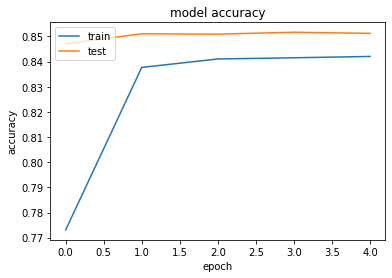

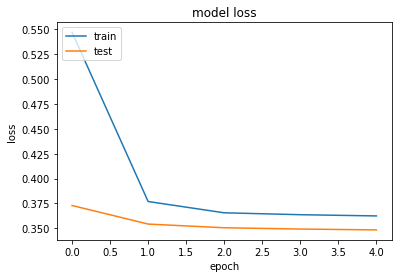

0.0


In [43]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

preds = model.predict(x_train)
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
print(accuracy(preds,y_train))

In [44]:
preds

array([[0.774679  , 0.01450918, 0.01053114, ..., 0.02916344, 0.02581992,
        0.31792173],
       [0.789705  , 0.01263186, 0.00844399, ..., 0.0245151 , 0.02352962,
        0.31405163],
       [0.79987186, 0.01169961, 0.00745545, ..., 0.02202516, 0.02204286,
        0.30596554],
       ...,
       [0.79465765, 0.01168069, 0.00767276, ..., 0.02241738, 0.02224088,
        0.31237358],
       [0.7918894 , 0.01349027, 0.0087975 , ..., 0.0248715 , 0.02386432,
        0.30599326],
       [0.8085357 , 0.01075056, 0.00658227, ..., 0.01935756, 0.02062545,
        0.30306157]], dtype=float32)

In [45]:
convert_2_labels(preds)

[[0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,

In [46]:
convert_2_labels(y_test)

[[0, 0, 0, 0, 2, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0],
 [0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 2, 0, 0, 3, 0],
 [3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 3, 3, 3, 0, 2, 0, 0, 3, 3],
 [3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3, 3, 0],
 [0, 0, 2, 0, 0, 0, 3, 3, 0, 0, 3, 3, 0, 3, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 2, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 3, 3],
 [0, 0, 0, 0, 3, 0, 2, 1, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 3, 0, 0, 0, 3, 3, 0, 0, 3, 3],
 [0, 0, 0, 0, 3, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 3],
 [3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 3, 3, 3, 3, 0, 3, 0, 0, 3, 0],
 [0, 0, 1, 0, 3, 0, 0, 2, 3, 0, 3, 0, 0, 3, 0, 3, 3, 0, 3, 0],
 [3, 0, 3, 0, 3, 0, 0, 2, 0, 3, 3, 3, 2, 2, 2, 2, 3, 0, 3, 0],
 [0, 0, 0, 3, 3, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 3, 0, 0, 3, 3],
 [0, 0, 1, 0, 3, 0, 0, 1, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3],
 [0, 0, 0, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 3, 0,

In [47]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [48]:
coun=0
all1=0
for line in convert_2_labels(preds):
    for item in line:
        if item == 1:
            coun+=1
        all1+=1

In [49]:
coun/all1

0.0

In [50]:
hahahahaha

NameError: name 'hahahahaha' is not defined

In [ ]:
class DataLoader():
    def __init__(self,filename,sampleNum):
        self.filename = filename
        self.data = self.load_data()
        random_indices = np.random.choice(np.arange(len(self.data['content'])), sampleNum)
        self.sub_data = self.data.iloc[random_indices]
        self.sub_data['content'] = self.sub_data['content'].apply(self.clean_sentence)

    def load_data(self):
        return pd.read_csv(self.filename,encoding='UTF-8')

    def is_CN_char(self,ch):
        return ch >= u'\u4e00' and ch <= u'\u9fa5'

    def cut(self,string):
        return list(jieba.cut(string))

    def get_stopwords(self,filename = "D:/senior/aiCourse/dataSource/stop_word.txt"):
        stopwords_dic = open(filename, encoding= 'utf-8')
        stopwords = stopwords_dic.readlines()
        stopwords = [w.strip() for w in stopwords]
        stopwords_dic.close()
        return stopwords

    def convert2simple(self,word):
        openCC = OpenCC('tw2sp')
        return openCC.convert(word)

    def clean_sentence(self,sentence):
        stopwords = self.get_stopwords()
        sentence = ''.join(filter(self.is_CN_char,sentence))
        #sentence = convert2simple(sentence)
        words = [w for w in self.cut(sentence) if len(w)>1 and w not in stopwords]
        words = ' '.join(words)
        return words


trainData = DataLoader('D:/senior/aiCourse/dataSource/comment_classification/train/sentiment_analysis_trainingset.csv',5000)


In [ ]:
testData = DataLoader('D:/senior/aiCourse/dataSource/comment_classification/test/sentiment_analysis_testa.csv',1000)

In [ ]:
class data2vec():
    def __init__(self,inputData):

        self.vocab = ' '.join(inputData['content']).split()
        
        self.vocab.append('unknown')
        
        self.word_to_id, self.id_to_word = self.word_to_id(self.vocab)

        self.comment_to_id = self.comment_to_id(self.word_to_id,inputData['content'])

        self.pad_comments = self.pad_sequences(self.comment_to_id,maxlen=200,padding='post',truncating='post')
        
    def word_to_id(self,vocab):
        counts = Counter(vocab)
        vocab = sorted(counts, key=counts.get, reverse=True)
        word_to_id = { word : i for i, word in enumerate(vocab)}
        id_to_word = {i:word for i,word in enumerate(vocab)}
        return word_to_id, id_to_word


    def comment_to_id(self,word_to_id,comments):
        comment_to_id = []
        for comment in comments:
            comment_to_id.append([word_to_id[word] for word in comment.split()] )
        return comment_to_id


    def pad_sequences(self,comment_to_id,maxlen,padding='post',truncating='post'):
        features = np.zeros((len(comment_to_id), maxlen), dtype=int)
        for i,comment in enumerate(comment_to_id):
            if len(comment) <= maxlen and padding == 'pre':
                features[i, -len(comment):] = np.array(comment)[:maxlen]
            if len(comment) <= maxlen and padding == 'post':
                features[i, :len(comment)] = np.array(comment)[:maxlen]
            if len(comment) > maxlen and truncating == 'post':
                features[i, :] = np.array(comment)[:maxlen]
            if len(comment) > maxlen and truncating == 'pre':
                features[i, :] = np.array(comment)[len(comment)-maxlen:]
        return features

In [ ]:
trainDataId = data2vec(trainData.sub_data)
testDataId = data2vec(testData.sub_data)

In [ ]:
y_train = trainData.sub_data[[ 'location_traffic_convenience',
       'location_distance_from_business_district', 'location_easy_to_find',
       'service_wait_time', 'service_waiters_attitude',
       'service_parking_convenience', 'service_serving_speed', 'price_level',
       'price_cost_effective', 'price_discount', 'environment_decoration',
       'environment_noise', 'environment_space', 'environment_cleaness',
       'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
       'others_overall_experience', 'others_willing_to_consume_again']].values

y_test =  testData.sub_data[[ 'location_traffic_convenience',
       'location_distance_from_business_district', 'location_easy_to_find',
       'service_wait_time', 'service_waiters_attitude',
       'service_parking_convenience', 'service_serving_speed', 'price_level',
       'price_cost_effective', 'price_discount', 'environment_decoration',
       'environment_noise', 'environment_space', 'environment_cleaness',
       'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
       'others_overall_experience', 'others_willing_to_consume_again']].values

for i in range(len(y_test)):
    for j in range(20):
        y_test[i][j]+=2

x_train,y_train,x_test,y_test = split_dataset(pad_comments,labels,0.8)